In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [36]:
train_path = "../dataset/preprocessed/netflix_train.csv"
val_path = "../dataset/preprocessed/netflix_val.csv"
test_path = "../dataset/preprocessed/netflix_test.csv"

train_data = pd.read_csv(train_path)
val_data = pd.read_csv(val_path)
test_data = pd.read_csv(test_path)


max_words = 1000
max_len = 20

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_data['title'] + ' ' + train_data['description'])

X_train = pad_sequences(tokenizer.texts_to_sequences(train_data['title'] + ' ' + train_data['description']), maxlen=max_len)
X_val = pad_sequences(tokenizer.texts_to_sequences(val_data['title'] + ' ' + val_data['description']), maxlen=max_len)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_data['title'] + ' ' + test_data['description']), maxlen=max_len)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data['target_ages'])
y_val = label_encoder.transform(val_data['target_ages'])
y_test = label_encoder.transform(test_data['target_ages'])

In [65]:
model = keras.Sequential([
    keras.layers.Embedding(input_dim=max_words, output_dim=10, input_length=max_len),
    keras.layers.Conv1D(64, 3, activation='relu'),
    keras.layers.GlobalMaxPooling1D(),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [66]:
history = model.fit(X_train, y_train, epochs=10, batch_size=256, validation_data=(X_val, y_val))

Epoch 1/10
25/25 [==============================] - 1s 12ms/step - loss: 1.3196 - accuracy: 0.4439 - val_loss: 1.2566 - val_accuracy: 0.4473
Epoch 2/10
25/25 [==============================] - 0s 5ms/step - loss: 1.2062 - accuracy: 0.4694 - val_loss: 1.2148 - val_accuracy: 0.4473
Epoch 3/10
25/25 [==============================] - 0s 6ms/step - loss: 1.1781 - accuracy: 0.4694 - val_loss: 1.2052 - val_accuracy: 0.4473
Epoch 4/10
25/25 [==============================] - 0s 6ms/step - loss: 1.1638 - accuracy: 0.4694 - val_loss: 1.1924 - val_accuracy: 0.4473
Epoch 5/10
25/25 [==============================] - 0s 5ms/step - loss: 1.1423 - accuracy: 0.4694 - val_loss: 1.1732 - val_accuracy: 0.4473
Epoch 6/10
25/25 [==============================] - 0s 5ms/step - loss: 1.1099 - accuracy: 0.4694 - val_loss: 1.1474 - val_accuracy: 0.4473
Epoch 7/10
25/25 [==============================] - 0s 5ms/step - loss: 1.0715 - accuracy: 0.4694 - val_loss: 1.1262 - val_accuracy: 0.4473
Epoch 8/10
25/25 [=

In [64]:
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=-1)
y_test_classes = y_test

loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy * 100:.2f}%')

42/42 [==============================] - 0s 1ms/step
Test Loss: 1.0687
Test Accuracy: 49.70%


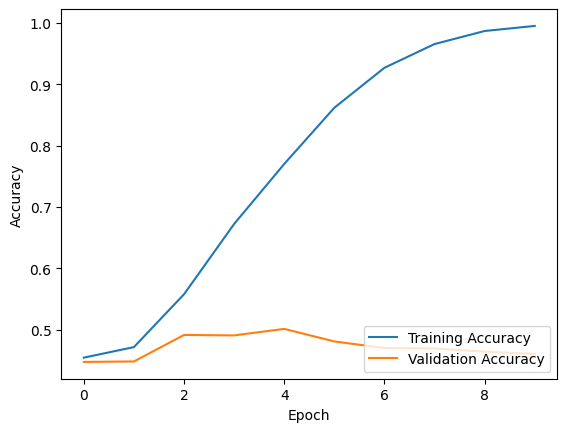

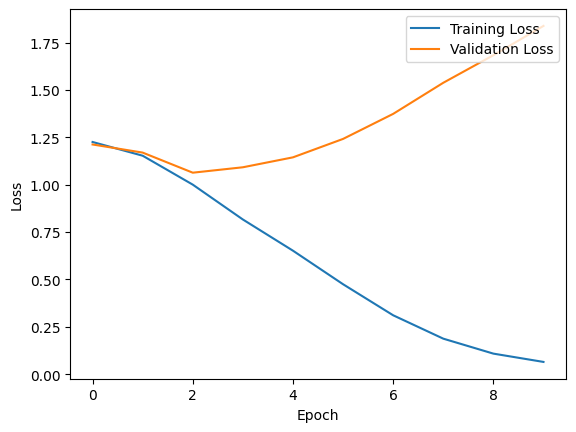

              precision    recall  f1-score   support

      Adults       0.57      0.62      0.60       614
        Kids       0.31      0.36      0.33        66
  Older Kids       0.40      0.33      0.36       242
       Teens       0.35      0.32      0.33       398

    accuracy                           0.47      1320
   macro avg       0.41      0.41      0.41      1320
weighted avg       0.46      0.47      0.46      1320



In [7]:

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

print(classification_report(y_test_classes, y_pred_classes, target_names=label_encoder.classes_))